# Oxygen Minimum Zone Boundary Detection Algorithm Validation

## Pull Data of Interest

In [1]:
from netCDF4 import Dataset
def pullData(fpath, fname):
    ds = Dataset(fpath+fname)
    
    # pull data
    lons = ds.variables['lon'][:]
    lats = ds.variables['lat'][:]
    deps = ds.variables['depth'][:]
    dO = ds.variables['o_an'][0][:][:][:]
        
    return lons, lats, deps, dO

In [2]:
# load dataset
fpath = 'data/'
fname = 'woa18_all_o01_01.nc'
lons, lats, deps, dO = pullData(fpath, fname)
print('lons shape:\t',lons.shape)
print('lats shape:\t',lats.shape)
print('deps shape:\t',deps.shape)
print('dO shape:\t',dO.shape)

lons shape:	 (360,)
lats shape:	 (180,)
deps shape:	 (57,)
dO shape:	 (57, 180, 360)


## Verify Latitude Indexing

Verify computation for the index of a given latitude, tested on 15 degrees N.

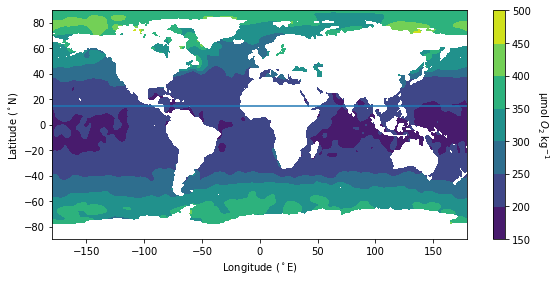

In [3]:
# import packages
import numpy as np
from matplotlib import pyplot as plt

# find target latitude
target_lat = 15
i_lat = int((target_lat + 89.5)/1.)

# load dataset
fpath = './data/'
fname = 'woa18_all_o01_01.nc'
lons, lats, deps, dO = pullData(fpath, fname)

# create full grids for each dimension
tempLat = []
tempLon = []

nLons = len(lons)
for lat in lats:
    tempLat.append(np.full(nLons, lat))
    tempLon.append(lons)

# cast to numpy arrays for easier handling
lats = np.array(tempLat)
lons = np.array(tempLon)
surface_dO = dO[0]

fig, ax = plt.subplots(figsize=(9.3, 4.2))  # create figure
dO_map = plt.contourf(lons, lats, surface_dO)       # create contour plot

# labels
cbar = plt.colorbar(dO_map)  # add colorbar
plt.ylabel('Latitude ($^\circ$N)')
plt.xlabel('Longitude ($^\circ$E)')
plt.axhline(y=lats[i_lat,0])
cbar.set_label('\u03BCmol $O_2$ kg$^{-1}$', rotation=270, labelpad=20)
plt.show()

The index appears to get the correct latitude because the horizontal line drawn using the index is at the correct latitude.

## Latitudinal Slice Function

In [4]:
def centerAtPacific(lons, ys, zs):
    # centers lons and zs to the Pacific Ocean and
    # pulls data for the specified longitudinal range
    
    # center global map at Pacific
    for i in range(len(lons)):
        for j in range(len(lons[0,:])):
            if lons[i,j] < 0:
                lons[i,j] += 360
    # reorder data (-180 - 180  --> 0 - 360)
    temp = 0
    for i in range(len(lons)):
        for j in range(180):
            temp = lons[i, j+180]
            lons[i, j+180] = lons[i,j]
            lons[i, j] = temp
            temp = zs[i, j+180]
            zs[i, j+180] = zs[i,j]
            zs[i,j] = temp
    
    # mask to keep only lons of the Pacific Ocean
    left = 125
    right = 260
    pacific_mask = (lons[0] > left) & (lons[0] < right)
    new_lon = []
    new_ys = []
    new_zs = []
    for i in range(len(lons)):
        new_lon.append(lons[i][pacific_mask])
        new_ys.append(ys[i][pacific_mask])
        new_zs.append(zs[i][pacific_mask])
    return new_lon, new_ys, new_zs

In [5]:
# import packages
from netCDF4 import Dataset
import numpy as np
from matplotlib import pyplot as plt

def getLatSlice(fpath, fname, target_lat):
    lons, lats, deps, dO = pullData(fpath, fname)

    # create full grids for each dimension
    tempLat = []
    tempLon = []
    tempDep = []

    nLons = len(lons)
    for lat in lats:
        tempLat.append(np.full(nLons, lat))
        tempLon.append(lons)
    for lon in lons:
        tempDep.append(deps)

    # cast to numpy arrays for easier handling
    lats = np.array(tempLat)
    lons = np.array(tempLon)
    deps = np.array(tempDep)
    
    # find index of latitude to perform the slice on
    lat_lo = lats[0,0]
    i_lat = int((target_lat - lat_lo)/1.)
    actual_lat = lats[i_lat,0]
    
    # create full grid for a latitudinal slice w/ depth
    lonVert = []
    for dep in deps[0,:]:
        lonVert.append(lons[i_lat,:])
    
    # format data for plot
    lonVert = np.array(lonVert)
    deps = np.transpose(deps)
    dO_slice = dO[:, i_lat, :]
    
    # center at Pacific
    new_lon, new_dep, new_dO = centerAtPacific(lonVert, deps, dO_slice)
    return i_lat, actual_lat, new_lon, new_dep, new_dO

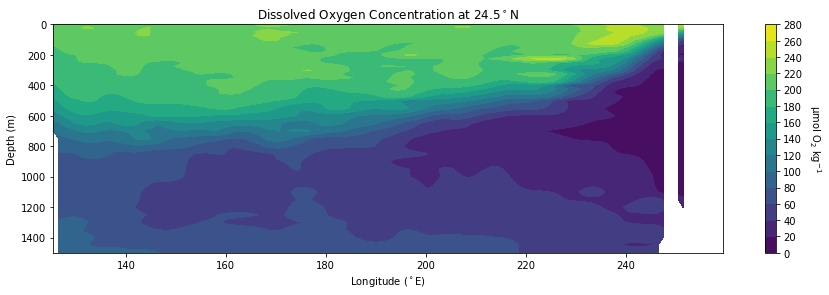

In [6]:
# Test getLatSlice
fpath = './data/'
fname = 'woa18_all_o03_01.nc'

target_lat = 25
i_lat, actual_lat, lons, deps, dO = getLatSlice(fpath, fname, target_lat)

breaks = np.linspace(0, 280, 15)

fig, ax = plt.subplots(figsize=(15, 4.2))      # create figure
dO_map = plt.contourf(lons, deps, dO, breaks)  # create contour plot

cbar = plt.colorbar(dO_map, ticks=breaks)  # add colorbar
plt.gca().invert_yaxis()                   # make depth go down
plt.title('Dissolved Oxygen Concentration at ' + str(actual_lat) + '$^\circ$N')
plt.ylabel('Depth (m)')
plt.xlabel('Longitude ($^\circ$E)')
cbar.set_label('\u03BCmol O$_2$ kg$^{-1}$', rotation=270, labelpad=20)
plt.show()

Latitudinal slice appears to work as intended!

## OMZBA

In [7]:
def omzbda(lons, deps, dO, threshold):
    top = 1500
    bottom = 0
    left = 360
    right = 0
    omzb_t = ()
    omzb_b = ()
    omzb_l = ()
    omzb_r = ()
    for i in range(len(dO)):
        for j in range(len(dO[0])):
            if dO[i][j] <= threshold:
                # in the OMZ core, so identify if bounds are present
                if deps[i][j] < top:
                    top = deps[i][j]
                    omzb_t = (lons[i][j], deps[i][j])
                if deps[i][j] > bottom:
                    bottom = deps[i][j]
                    omzb_b = (lons[i][j], deps[i][j])
                if lons[i][j] < left:
                    left = lons[i][j]
                    omzb_l = (lons[i][j], deps[i][j])
                if lons[i][j] > right:
                    right = lons[i][j]
                    omzb_r = (lons[i][j], deps[i][j])
                
    return top, bottom, left, right, omzb_t, omzb_b, omzb_l, omzb_r

top: 85.0 (258.5, 85.0)
bot: 1100.0 (248.5, 1100.0)
west: 211.5 (211.5, 600.0)
east: 259.5 (259.5, 85.0)


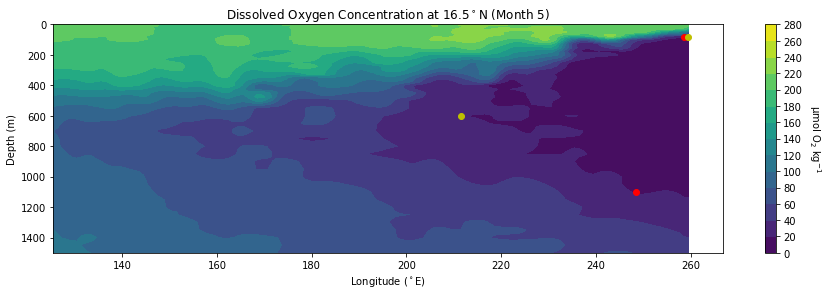

In [8]:
# Test getLatSlice
fpath = './data/'
fname = 'woa18_all_o02_01.nc'

target_lat = 17
i_lat, actual_lat, lons, deps, dO = getLatSlice(fpath, fname, target_lat)

top, bottom, left, right, t_pt, b_pt, l_pt, r_pt = omzbda(lons, deps, dO, 20)
print('top:', top, t_pt)
print('bot:', bottom, b_pt)
print('west:', left, l_pt)
print('east:', right, r_pt)

breaks = np.linspace(0, 280, 15)

fig, ax = plt.subplots(figsize=(15, 4.2))      # create figure
dO_map = plt.contourf(lons, deps, dO, breaks)  # create contour plot

cbar = plt.colorbar(dO_map, ticks=breaks)  # add colorbar
plt.gca().invert_yaxis()                   # make depth go down
ax.set_title('Dissolved Oxygen Concentration at ' + str(actual_lat) + '$^\circ$N (Month 5)')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Longitude ($^\circ$E)')
cbar.set_label('\u03BCmol O$_2$ kg$^{-1}$', rotation=270, labelpad=20)

# plot upper and lower bounds identified by OMZ-BDA
x,y = zip(*[t_pt, b_pt])
ax.scatter(x, y, color='r')
x,y = zip(*[l_pt, r_pt])
ax.scatter(x, y, color='y')
plt.show()

fig_path = './figures/'
fname = 'ex_omzba.png'
fig.tight_layout()
fig.savefig(fig_path+fname, dpi=80)